## Imports

In [2]:
%matplotlib inline
import json
import copy
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL.Image
import cmapy
import rasterio
from rasterio.mask import mask

## Constants

In [16]:
# image files
IMAGE_FROM_SAT = './data/images/image_from_sat.tiff'
IMAGE_FROM_SAT_PNG = './data/images/image_from_sat.png'
IMAGE_COLORED = './data/images/image_colored.png'

# data
ORIGINAL_GEOJSON = './data/geojson/green_roofs_original.geojson'
FIXED_GEOJSON = './data/geojson/green_roofs.geojson'
BB1_GEOJSON = './data/geojson/bb1_green_roofs.geojson'
BB2_GEOJSON = './data/geojson/bb2_green_roofs.geojson'
BB_CENTER_GEOJSON = './data/geojson/bb_center_green_roofs.geojson'
BB1_CAT_GEOJSON = './data/geojson/bb1_cat_green_roofs.geojson'
BB2_CAT_GEOJSON = './data/geojson/bb2_cat_green_roofs.geojson'

# js files
FIXED_JS = './data/js/green_roofs.js'
BB1_JS = './data/js/bb1_green_roofs.js'
BB2_JS = './data/js/bb2_green_roofs.js'
BB_CENTER_JS = './data/js/bb_center_green_roofs.js'
BB1_CAT_JS = './data/js/bb1_cat_green_roofs.js'
BB2_CAT_JS = './data/js/bb2_cat_green_roofs.js'

## Visualization

In [4]:
def open_image(file_name):
    """
    Read image from disk. OpenCV library is used because of better performance over PIL.
    :param file_name: str or PosixPath, path to image
    :return: image
    """
    flags = cv2.IMREAD_UNCHANGED + cv2.IMREAD_ANYDEPTH + cv2.IMREAD_ANYCOLOR

    im = cv2.imread(str(file_name), flags).astype(np.float32) / 255
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [5]:
def show_image(image, figure_size=(16, 12), axis=None):
    """
    Display image in matplotlib figure
    :param image: openCV image
    :param figure_size: size of figure
    :param axis:
    :return:
    """
    if not axis:
        figure, axis = plt.subplots(figsize=figure_size)
    axis.imshow(image, aspect='auto')
    return axis

## Process .tiff from sattelite and create .png

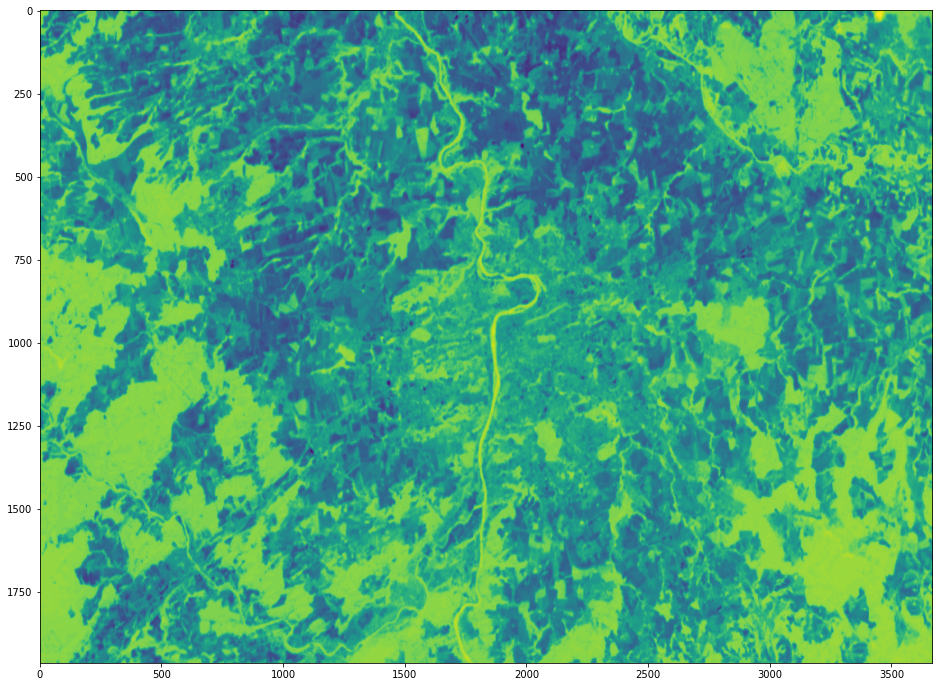

In [6]:
with rasterio.open(IMAGE_FROM_SAT) as red_file:
    data = red_file.read()[0]
    data_max = np.max(data)
    data_min = np.min(data)
    # convert to 0-256 values
    bit8 = ((((data - data_min) * (255 - 0)) / (data_max - data_min)) + 0).astype('uint8')
    image = PIL.Image.fromarray(bit8, "L")

    # display and save image
    show_image(image)
    image.save(IMAGE_FROM_SAT_PNG,"PNG")

## Convert grayscale to Red color map

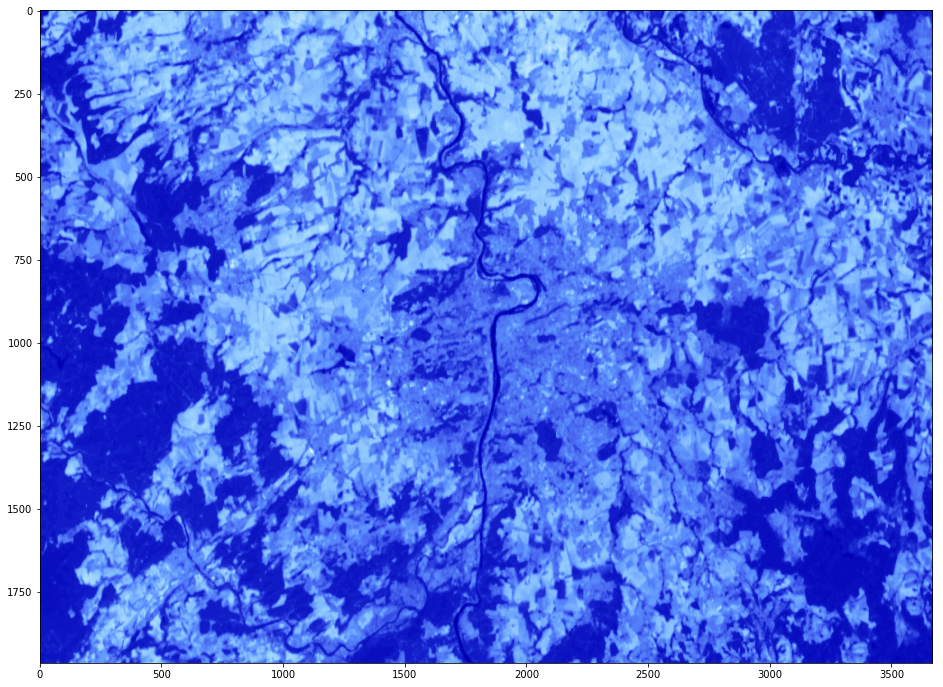

In [7]:
image_gray = cv2.imread(IMAGE_FROM_SAT_PNG, cv2.IMREAD_GRAYSCALE)
# color map has been choosen from 
# https://matplotlib.org/examples/color/colormaps_reference.html
image_colored = cv2.applyColorMap(image_gray, cmapy.cmap('OrRd'))

cv2.imwrite(IMAGE_COLORED, image_colored)
show_image(image_colored)

### Note: matplotlib displays different colormaps that images really have. Open image from disk to see real colors

## Data processing

This section is processing data about green roofs created by golemio.cz

You need to [download GeoJSON file with data](http://opendata.praha.eu/dataset/27691e08-aec1-4ad3-a2b5-3a3c6e8c61d2/resource/17a0dbd5-6a10-47e0-a9d3-86c0170cd205/download/45c734a3-d3ad-44ab-9ae8-2f0bfeec0372-zelenestrechy.geojson) first and save it as `green_roofs_original.geojson`

We find out that data doesn't really fits on the map (it is few meters difference), but it can be fixed by following this process:
1. Install `gdal` and `ogr` packages. (`brew install gdal` on MacOS, `dnf install gdal` on Fedora or `sudo apt-get install gdal-bin` on Ubuntu)
2. Run this commands:
 
    ```bash
    $ ogr2ogr -f GPKG -s_srs "+init=epsg:4326" -t_srs "+init=epsg:5514" ./new_gr.gpkg ./green_roofs_original.geojson
    ```
    
    Then:
    
    ```bash
    $ ogr2ogr -f geojson -s_srs "+proj=krovak +lat_0=49.5 +lon_0=24.83333333333333 +alpha=30.28813972222222 +k=0.9999 +x_0=0 +y_0=0 +ellps=bessel +towgs84=570.8,85.7,462.8,4.998,1.587,5.261,3.56 +units=m +no_defs" -t_srs "+init=epsg:4326" ./green_roofs.geojson ./new_gr.gpkg
    ```

Now you should have fixed geojson in `green_roofs.geojson`.

## Filtering functions

As we want to display data on map using [Leaflet](https://leafletjs.com/) it comes really handy to generate JS files from geojson.

In [8]:
def create_js_from_geojson(input_file, output_file, var_name):
    with open(input_file, 'r+') as f1:
            content = f1.read()
    with open(output_file, 'w+') as f2:
        f2.write("var " + var_name + "= [" + content + "]")

Our data file `green_roofs.geojson` contains buildings divided to 5 categories. This function provides functionality to filter just categories thamt you want and create new .geojson just with them.

In [9]:
def filter_categories(input_json, output_json, category_names=None):
    """
    Filter buildings from specific categories
    :param input_json: str
    :param output_json: str
    :param category_names: list of categories 
    """
    with open(input_json, 'r') as json_file:
        data = json.load(json_file)
        if not category_names:
            with open(output_json, 'w') as outfile:
                json.dump(data, outfile)
        else:
            out_data = {"type": "FeatureCollection", "features": []}
            features = data["features"]
            
            for index, obj in enumerate(features):
                properties = obj["properties"]

                for category in category_names:
                    if properties[category] == True:
                        object_ids = [f["properties"]["objectid"] for f in out_data["features"]]
                        if not (properties["objectid"] in object_ids):  # avoid duplicates 
                            out_data["features"].append(copy.deepcopy(obj))
                        
            with open(output_json, 'w') as outfile:
                print(len(out_data["features"]))
                json.dump(out_data, outfile)


This function provides functionality to filter just buildings surronded by borders of rectangle bounding box.

In [13]:
def bounding_box_subset(input_json, output_json, bounding_box):
    """
    Filter just buildings surrounded by bounding box.
    :param input_json: str
    :param output_json: str
    :param bounding_box: list, [x1,y1,x2,y2] Left top and Bottom right corner coordinates
    :return: image
    """
    
    with open(input_json, 'r') as json_file:
        data = json.load(json_file)
        if not bounding_box:
            with open(output_json, 'w') as outfile:
                json.dump(data, outfile)
        else:
            out_data = {"type": "FeatureCollection", "features": []}
            features = data["features"]
            
            print(len(features))
            
            for index, obj in enumerate(features):
                properties = obj["properties"]
                coordinates = obj["geometry"]["coordinates"][0][0]
                
                for item in coordinates:
                    if bounding_box[0] <= item[0] <= bounding_box[2]:
                        if bounding_box[1] >= item[1] >= bounding_box[3]:
                            object_ids = [f["properties"]["objectid"] for f in out_data["features"]]
                            if not (properties["objectid"] in object_ids):
                                out_data["features"].append(copy.deepcopy(obj))
                    
            
            with open(output_json, 'w') as outfile:
                print(len(out_data["features"]))
                json.dump(out_data, outfile)

Create first bounding box

In [10]:
bounding_box_subset(FIXED_GEOJSON,
                    BB1_GEOJSON,
                    [14.428063, 50.090759, 14.437146,50.087322])

create_js_from_geojson(BB1_GEOJSON,
                       BB1_JS, 'geo_bb1')

31


Create second box

In [18]:
bounding_box_subset(FIXED_GEOJSON,
                    BB2_GEOJSON,
                    [14.424331, 50.086436, 14.432383,50.081072])

create_js_from_geojson(BB2_GEOJSON,
                       BB2_JS,
                       'geo_bb2')

21338
61


Center of Prague

In [17]:
bounding_box_subset(FIXED_GEOJSON,
                    BB_CENTER_GEOJSON,
                    [14.398705, 50.096717, 14.458234, 50.062061])

create_js_from_geojson(BB2_GEOJSON,
                       BB_CENTER_JS,
                       'geo_bb_center')

21338
1050


Create first bounding box with filtered categories

In [12]:
filter_categories(BB1_GEOJSON,
                  BB1_CAT_GEOJSON,
                  ["Kategorie I", "Kategorie II"])

create_js_from_geojson(BB1_CAT_GEOJSON,
                       BB1_CAT_JS, 'geo_bb1')

8


Create second bounding box with filtered categories

In [19]:
filter_categories(BB2_GEOJSON,
                  BB2_CAT_GEOJSON,
                  ["Kategorie I", "Kategorie II"])

create_js_from_geojson(BB2_CAT_GEOJSON,
                       BB2_CAT_JS, 'geo_bb2')

13


Create JS from whole geojson `green_roofs.geojson`

In [12]:
create_js_from_geojson(FIXED_GEOJSON,
                       FIXED_JS, 'geo')